In [2]:
import numpy as np
import pandas as pd
import os
from os.path import join, exists
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import json
from PIL import Image
import importlib
H = importlib.import_module("projects.al-benchmark.core.helper_functions")

def shuffle(v):
    ids = np.arange(len(v))
    np.random.shuffle(ids)
    return v[ids]

def auc(values):
    v = np.sum(values, axis=1) / values.shape[1]
    return np.squeeze(v)

def mean_std_curves(inpt):
    mean_develop = [np.median(inpt[:i]) for i in range(1, len(inpt) + 1)]
    # median_develop = [np.median(inpt[:i]) for i in range(1, len(inpt) + 1)]
    std_develop = [np.std(inpt[:i]) for i in range(1, len(inpt) + 1)]
    return mean_develop, std_develop

def plot(ax, points, trajectories, twin, color, title):
    # ax.set_ylabel("mean")
    ax.set_xlabel("eval run")
    ax.scatter(range(len(points)), points, c="r", s=9, alpha=0.3)
    ax.grid()
    if twin:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    for line in trajectories:
        ax2.plot(line, c=color, alpha=0.3)
    ax2.grid()
    ax.set_title(title)

In [5]:
import torch
import yaml
def plot_synthdata(dataset, name, dot_size):
    y = torch.cat((dataset.y_train, dataset.y_val, dataset.y_test), dim=0)
    y = y.cpu()
    X = torch.cat((dataset.x_train, dataset.x_val, dataset.x_test), dim=0)
    X = X.cpu()

    #print(y)
    class_indices = np.argmax(y, axis=1)
    matched_data = [(X[i], class_indices[i]) for i in range(len(X))]

    pos_cls = []
    neg_cls = []

    for data in matched_data:
        if data[1] == 0:
            pos_cls.append(data[0])
        else:
            neg_cls.append(data[0])

    pos_x = [tensor[0].item() for tensor in pos_cls]
    pos_y = [tensor[1].item() for tensor in pos_cls]

    neg_x = [tensor[0].item() for tensor in neg_cls]
    neg_y = [tensor[1].item() for tensor in neg_cls]


    fig, ax = plt.subplots()
    ax.scatter(pos_x, pos_y, s=dot_size, label = 'Class A')
    ax.scatter(neg_x, neg_y, s=dot_size, label = 'Class B')
    plt.title(name + ' Dataset')

Loaded dataset: DivergingSin
| Number of classes: 2
| Labeled Instances: 20
| Unlabeled Instances: 1260
| Val Instances 320
| Test Instances 400


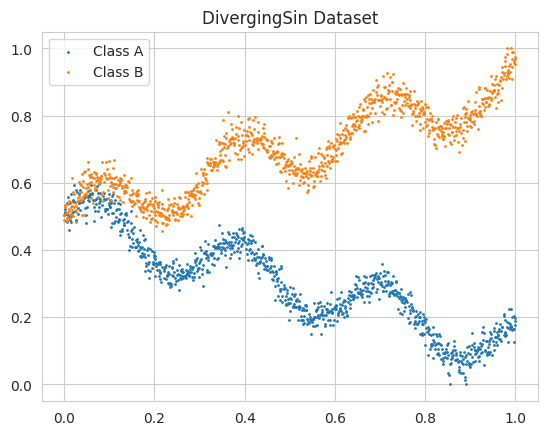

In [6]:
from datasets.sythData import DivergingSin

with open(f"configs/divergingsin.yaml", 'r') as f:
    config = yaml.load(f, yaml.Loader)
dataset_sin = DivergingSin("", config, pool_rng = np.random.default_rng(20), encoded=False)
plot_synthdata(dataset_sin,  'DivergingSin', 1)

plt.legend()
plt.show()

Loaded dataset: ThreeClust
| Number of classes: 2
| Labeled Instances: 20
| Unlabeled Instances: 364
| Val Instances 96
| Test Instances 120


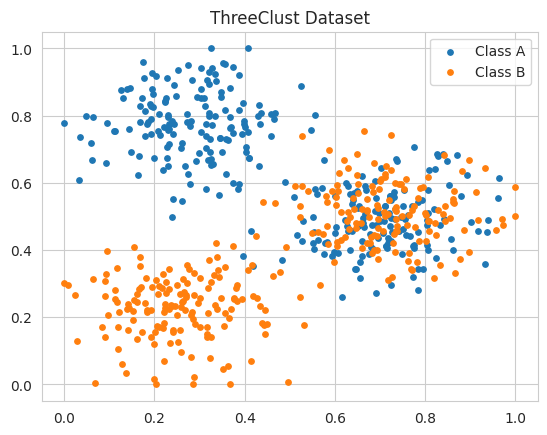

In [7]:
from datasets.sythData import ThreeClust

dataset_3Clust = ThreeClust("", config, pool_rng = np.random.default_rng(20), encoded=False)
plot_synthdata(dataset_3Clust,  'ThreeClust', 15)
plt.legend()
plt.show()

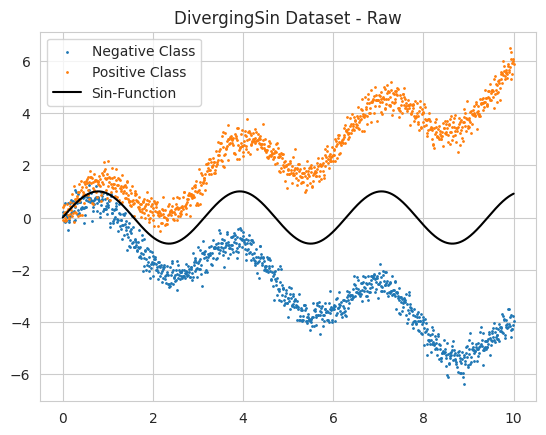

In [6]:
def PlotDivergingSin(n_samples=1000, divergence_factor=0.5, sin_freq=2, cov=0.3):
    pool_rng = np.random.default_rng(20)
    dot_size = 1

    x = np.linspace(0, 10, n_samples)
    sin_curve = np.sin(sin_freq*x)

    # Cluster above the curve
    cluster_above_x = x
    cluster_above_y = sin_curve + divergence_factor * x + pool_rng.normal(0, cov, n_samples)
    cluster_above = np.c_[cluster_above_x, cluster_above_y]

    # Cluster below the curve
    cluster_below_x = x
    cluster_below_y = sin_curve - divergence_factor * x + pool_rng.normal(0, cov, n_samples)
    cluster_below = np.c_[cluster_below_x, cluster_below_y]


    data_pos = np.c_[cluster_above, np.ones(len(cluster_above_y))]
    data_neg = np.c_[cluster_below, np.zeros(len(cluster_below_y))]

    fig, ax = plt.subplots()
    ax.scatter(data_neg[:,0], data_neg[:,1], s=dot_size, label = 'Negative Class')
    ax.scatter(data_pos[:,0], data_pos[:,1], s=dot_size, label = 'Positive Class')

    ax.plot(x, sin_curve , color='k', label = 'Sin-Function')
    plt.title('DivergingSin Dataset - Raw')
    plt.legend()
    plt.show()

PlotDivergingSin()

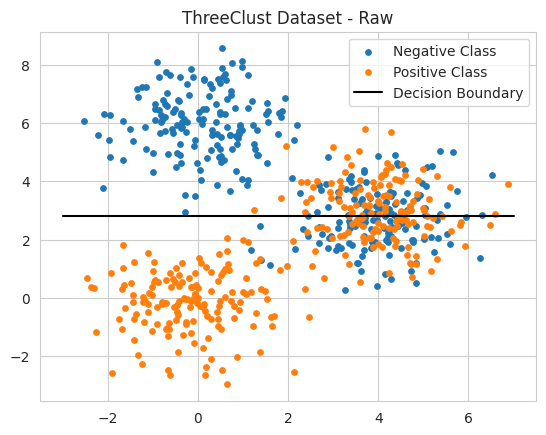

In [7]:
def PlotDivergingSin(n_perClust=150, cov=[[1, 0], [0, 1]]):
    pool_rng = np.random.default_rng(20)
    dot_size = 15

    mean1 = [0, 0]
    cluster1 = pool_rng.multivariate_normal(mean1, cov, n_perClust)

    mean2 = [4, 3]
    cluster2 = pool_rng.multivariate_normal(mean2, cov, n_perClust)

    mean3 = [0, 6]
    cluster3 = pool_rng.multivariate_normal(mean3, cov, n_perClust)

    mean4 = [4, 3]
    cluster4 = pool_rng.multivariate_normal(mean4, cov, n_perClust)

    data_pos = np.concatenate((cluster1, cluster2), axis=0)
    data_neg = np.concatenate((cluster3, cluster4), axis=0)

    data_pos = np.c_[data_pos, np.ones(len(data_pos))]
    data_neg = np.c_[data_neg, np.zeros(len(data_neg))]

    fig, ax = plt.subplots()
    ax.scatter(data_neg[:,0], data_neg[:,1], s=dot_size, label = 'Negative Class')
    ax.scatter(data_pos[:,0], data_pos[:,1], s=dot_size, label = 'Positive Class')

    x = np.arange(-3, 8)
    y = 0 * x + 2.8
    ax.plot(x, y, c='black', label="Decision Boundary")

    plt.title('ThreeClust Dataset - Raw')
    plt.legend()
    plt.show()

PlotDivergingSin()

# Mean / STD convergence

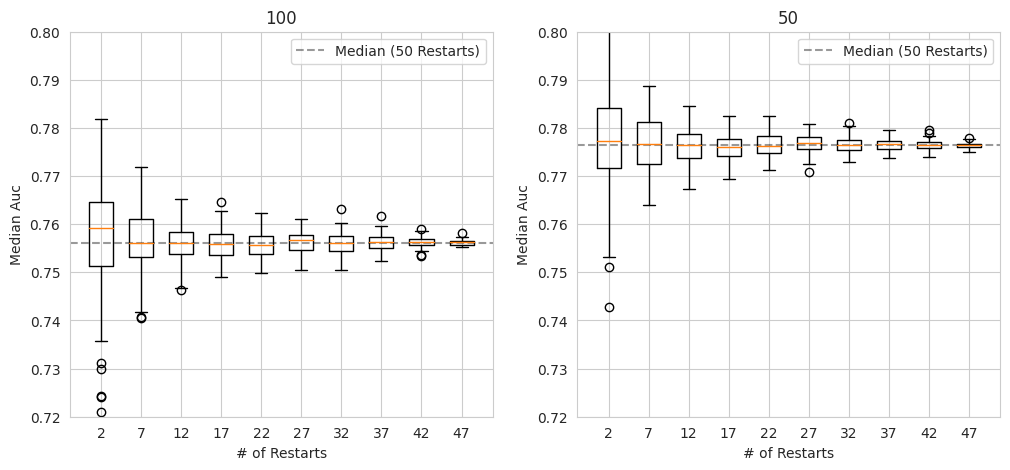

In [19]:
import scipy.stats as stats

def do_box(ax, file, title, y_min, y_max):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    accuracies = accuracies.dropna(axis=0)
    values = auc(accuracies.values.T)
    true_median = np.mean(values)
    medians = []
    sizes = []
    for size in range(2, len(values), 5):
        current = []
        for _ in range(100):
            v = shuffle(values)[:size]
            current.append(np.mean(v))
        medians.append(current)
        sizes.append(size)
    ax.axhline(true_median, label="Median (50 Restarts)", linestyle="--", c="black", alpha=0.4)
    # ax.axhline(0.814, label="Oracle", linestyle="--", c="red", alpha=0.4)
    ax.boxplot(medians, widths=3, positions=sizes)
    ax.set_xlabel("# of Restarts")
    ax.set_ylabel("Median Auc")
    ax.set_title(title)
    ax.set_ylim(y_min, y_max)
    ax.legend()

def do_normal(ax, file, title):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    accuracies = accuracies.dropna(axis=0)
    values = auc(accuracies.values.T)
    true_median = np.mean(values)
    ax.axvline(true_median, label="Median (50 Restarts)", linestyle="--", c="black", alpha=0.4)
    for size in range(2, len(values), 10):
        current = []
        for _ in range(50):
            v = shuffle(values)[:size]
            current.append(np.mean(v))
        std = np.std(current)
        x = np.linspace(true_median - 3*std, true_median + 3*std, 100)
        ax.plot(x, stats.norm.logpdf(x, true_median, std), label=f"{size} Restarts")
    ax.set_xlabel("Median Auc")
    ax.set_ylabel("Log Density")
    ax.set_title(title)
    # ax.set_yscale("log")
    ax.legend()

np.random.seed(2023)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
do_box(ax1, "runs/Splice/100/Badge/accuracies.csv", "100", 0.72, 0.8)
do_box(ax2, "runs/Splice/50/Badge/accuracies.csv", "50", 0.72, 0.8)

# do_box(ax1, "runs/Splice/ShannonEntropy/accuracies.csv", "From Scratch", 0.74, 0.82)
# do_box(ax2, "runs/Splice/ShannonEntropy_finetuned/accuracies.csv", "Finetuning", 0.74, 0.82)
# # plt.savefig("doc/img/ablation_restarts.jpg")
# plt.show()
# plt.close(fig)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# do_normal(ax1, "runs/Splice/RandomAgent/accuracies.csv", "Random")
# do_normal(ax2, "runs/Splice/MarginScore/accuracies.csv", "Margin")
# # plt.savefig("doc/img/ablation_restarts_2.jpg")
# plt.show()
# plt.close(fig)


NameError: name 'do_box' is not defined

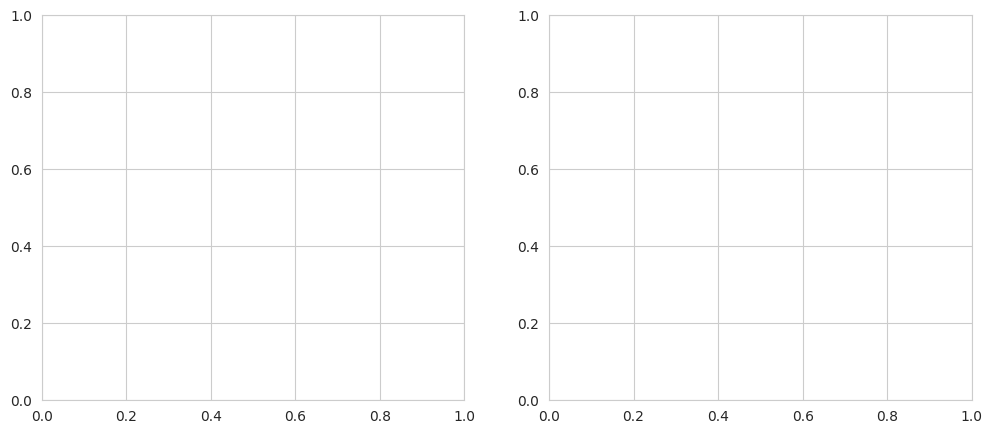

In [4]:
np.random.seed(2023)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
do_box(ax1, "runs/Cifar10Encoded/RandomAgent/accuracies.csv", "Random", 0.58, 0.67)
do_box(ax2, "runs/Cifar10Encoded/BALD/accuracies.csv", "BALD", 0.58, 0.67)
plt.savefig("doc/img/ablation_cifar_restarts.jpg")
plt.show()
plt.close(fig)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
do_normal(ax1, "runs/Cifar10Encoded/RandomAgent/accuracies.csv", "Random")
do_normal(ax2, "runs/Cifar10Encoded/MarginScore/accuracies.csv", "Margin")
plt.savefig("doc/img/ablation_cifar_restarts_2.jpg")
plt.show()
plt.close(fig)


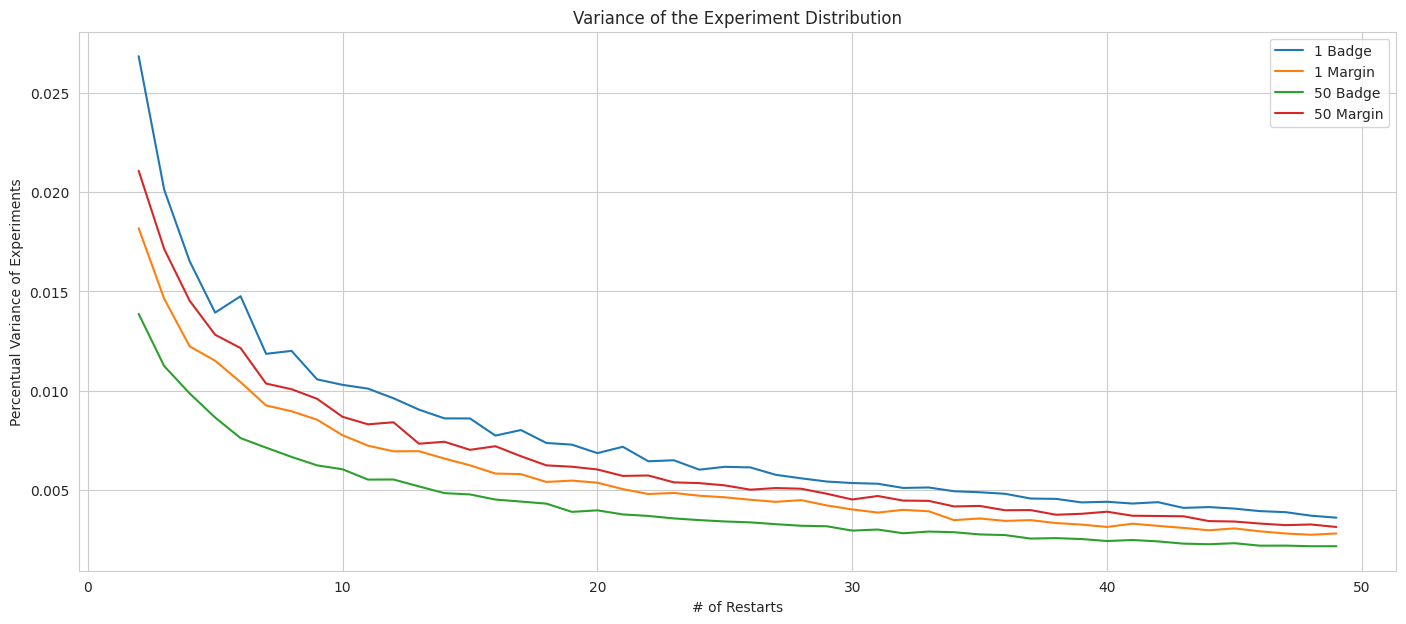

In [30]:
def do_line(ax, files:list, n_restarts=50):
    for file, label in files:
        accuracies = pd.read_csv(file, header=0, index_col=0)
        accuracies = accuracies.dropna(axis=0)
        values = auc(accuracies.values.T)
        true_mean = np.mean(values)
        stds = []
        sizes = []
        n_restarts = min(n_restarts, len(values))
        for size in range(2, n_restarts):
            current = []
            for _ in range(1000): # draw 1000 samples from the experiment distribution
                v = shuffle(values)[:size]
                current.append(np.mean(v))
            stds.append(np.std(current) / true_mean)
            sizes.append(size)
        ax.plot(sizes, stds, label=label)
    ax.set_xlabel("# of Restarts")
    ax.set_ylabel("Percentual Variance of Experiments")
    ax.legend()
    ax.set_title("Variance of the Experiment Distribution")

_, axes = plt.subplots(figsize=(17, 7))
do_line(axes, [
    ("runs/Splice/1/Badge/accuracies.csv", "1 Badge"),
    ("runs/Splice/1/MarginScore/accuracies.csv", "1 Margin"),
    # ("runs/Splice/5/Badge/accuracies.csv", "5 Badge"),
    # ("runs/Splice/5/MarginScore/accuracies.csv", "5 Margin"),
    # ("runs/Splice/20/Badge/accuracies.csv", "20 Badge"),
    # ("runs/Splice/20/MarginScore/accuracies.csv", "20 Margin"),
    ("runs/Splice/50/Badge/accuracies.csv", "50 Badge"),
    ("runs/Splice/50/MarginScore/accuracies.csv", "50 Margin"),
    # ("runs/Splice/100/Badge/accuracies.csv", "100 Badge"),
    # ("runs/Splice/100/MarginScore/accuracies.csv", "100 Margin"),
])

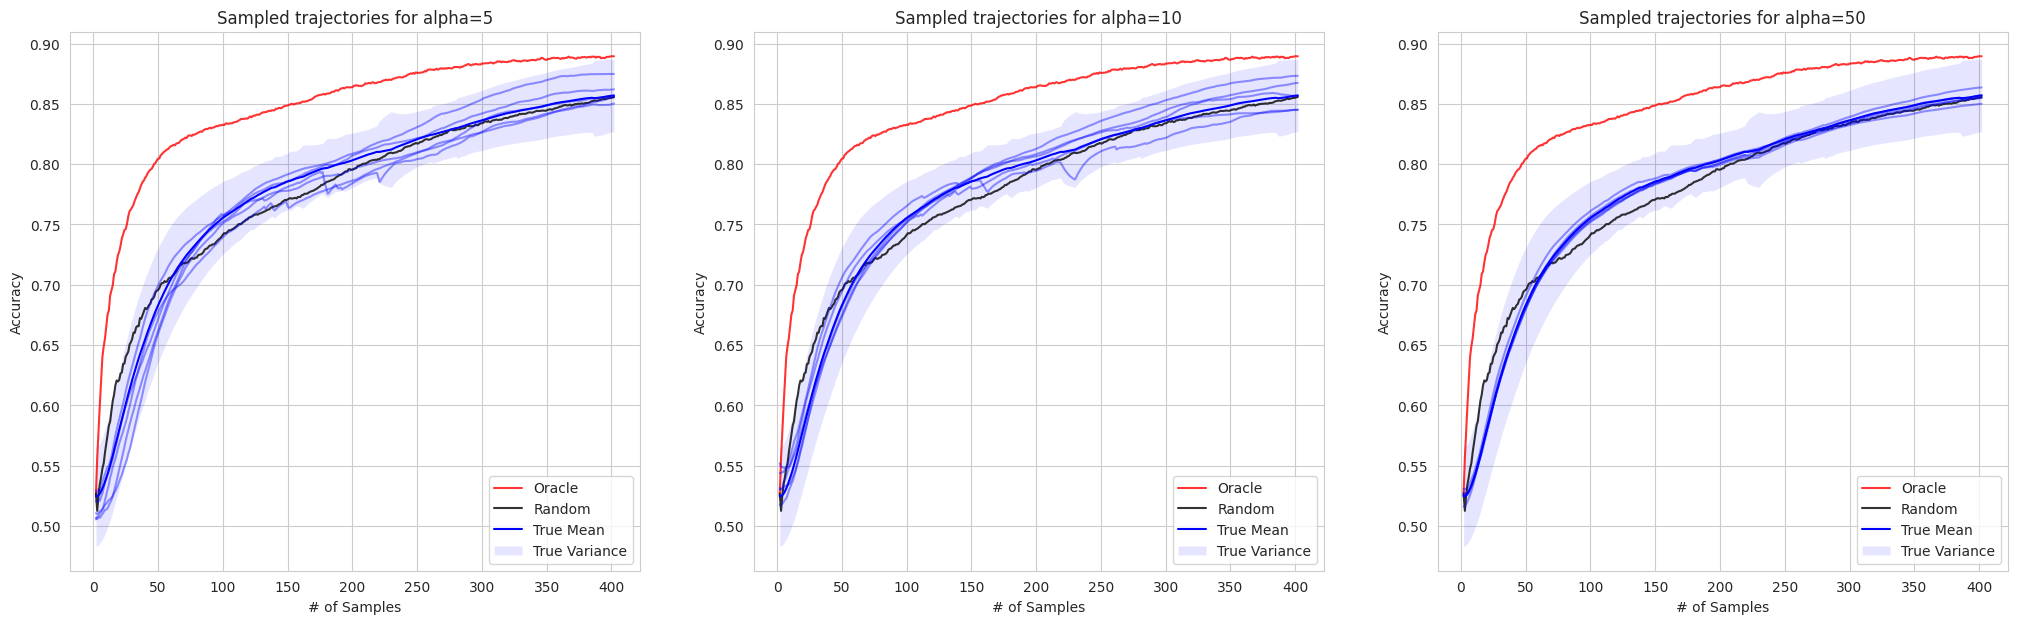

In [6]:
def sample_trajectories(ax, file, n_runs=5, n_restarts=5, smoothing_weight=0.0):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    accuracies = accuracies.dropna(axis=0)
    x = list(accuracies.index)
    x = [i + H.get_init_pool_size(dataset) for i in x]
    for _ in range(n_runs):
        v = shuffle(accuracies.values.T)[:n_restarts]
        mean = np.mean(v, axis=0)
        mean = H._moving_avrg(mean, smoothing_weight)
        ax.plot(x, mean, c=color, alpha=0.4)
    mean = np.mean(accuracies.values.T, axis=0)
    std = np.std(accuracies.values.T, axis=0)
    mean = H._moving_avrg(mean, smoothing_weight)
    std = H._moving_avrg(std, smoothing_weight)
    ax.plot(x, mean, c=color, label="True Mean")
    ax.fill_between(x, mean-std, mean+std, alpha=0.1, facecolor="blue", label="True Variance")
    ax.set_xlabel("# of Samples")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"Sampled trajectories for alpha={n_restarts}")
    ax.legend(loc="lower right")

color = "blue"
dataset = "Splice"
query_size = 1
smoothing = 0.9
_, axes = plt.subplots(1, 3, figsize=(25, 7))
for ax in axes:
    x, mean, std = H._load_eval_data(dataset, query_size, "Oracle", smoothing_weight=0.0)
    H.plot_batch_benchmark(ax, x, mean, "red", "Oracle", show_auc=False)
    x, mean, std = H._load_eval_data(dataset, query_size, "RandomAgent", smoothing_weight=0.0)
    H.plot_batch_benchmark(ax, x, mean, "black", "Random", show_auc=False)
sample_trajectories(axes[0], f"runs/{dataset}/{query_size}/MarginScore/accuracies.csv", n_restarts=5, smoothing_weight=smoothing)
sample_trajectories(axes[1], f"runs/{dataset}/{query_size}/MarginScore/accuracies.csv", n_restarts=10, smoothing_weight=smoothing)
sample_trajectories(axes[2], f"runs/{dataset}/{query_size}/MarginScore/accuracies.csv", n_restarts=50, smoothing_weight=smoothing)
plt.savefig("doc/img/ablation_restarts.jpg")

# Tukey Test for Statistical Significance

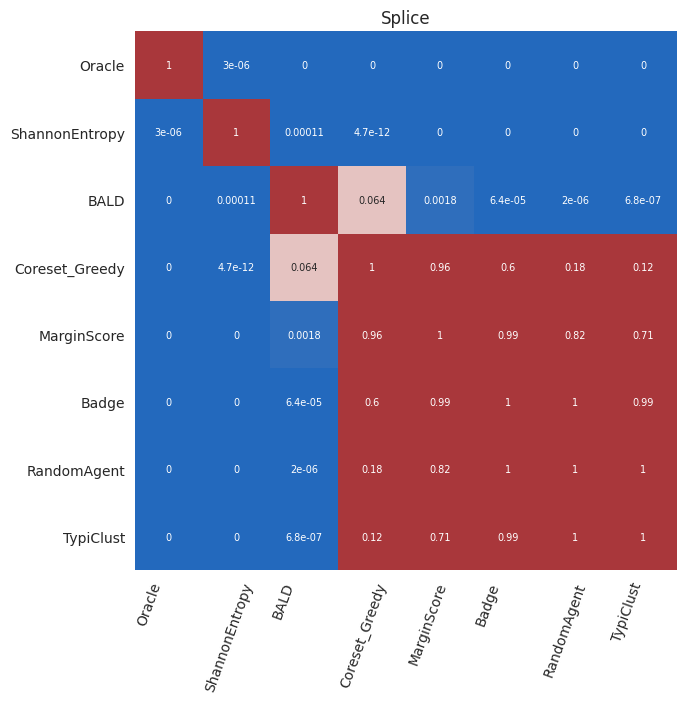

In [12]:
from scipy.stats import tukey_hsd
import os
from os.path import exists, join
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def _pad_nans_with_last_value(df:pd.DataFrame):
    max_len = len(df)
    for col in df:
        diff = max_len - sum(pd.notna(df[col]))
        if diff > 0:
            last_val = df[col][sum(pd.notna(df[col])) - 1]
            df[col] = pd.concat([df[col].iloc[:-diff], pd.Series([last_val]*diff)], ignore_index=True)
    return df

def do_tukey(agents, dataset):
    dataset_folder = os.path.join("runs", dataset)
    all_means = []
    all_aucs = []

    for agent in agents:
        agent_folder = join(dataset_folder, agent)
        if exists(agent_folder):
            acc_file = join(agent_folder, "accuracies.csv")
            if exists(acc_file):
                accuracies = pd.read_csv(acc_file, header=0, index_col=0)
                accuracies = _pad_nans_with_last_value(accuracies)
                values = accuracies.values
                auc = np.sum(values, axis=0) / values.shape[0]
                means = np.mean(auc).item()
                all_means.append(means)
                all_aucs.append(auc)
        else:
            print(f"{agent} is missing for {dataset}")
    z = zip(all_means, all_aucs, agents)
    z = sorted(z)
    all_means, all_aucs, agents = zip(*z)
    all_means = all_means[::-1]
    all_aucs = all_aucs[::-1]
    agents = agents[::-1]
    res = tukey_hsd(*all_aucs)

    p = (res.pvalue > 0.05).astype(int)
    fig, ax = plt.subplots(figsize=(7,7))
    cmap = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap(res.pvalue, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=0.1, center=0.05,
                annot=True, annot_kws={"size": 7})
    ax.set_yticks(np.arange(len(agents)), agents, rotation=0)
    for label in ax.yaxis.get_majorticklabels():
        offset = matplotlib.transforms.ScaledTranslation(0, -0.35, fig.dpi_scale_trans)
        label.set_transform(label.get_transform() + offset)
    ax.set_xticks(np.arange(len(agents)), agents, rotation=70, ha="left")


agents = ["Oracle", "Coreset_Greedy", "TypiClust", "MarginScore", "ShannonEntropy", "RandomAgent", "Badge", "BALD", ]
vector_data = ["Splice", "DNA", "USPS"]
enc_vector_data = ["SpliceEncoded", "DNAEncoded", "USPSEncoded"]
img_data = ["Cifar10Encoded", "FashionMnistEncoded"]
text_data = ["TopV2", "News"]

res = do_tukey(agents, "Splice")
plt.title("Splice")
print()

# Reward vs. Raw Diff

In [14]:
dataset = "Splice/5/RandomAgent"
file = os.path.join("/home/thorben/phd/projects/al-benchmark/runs", dataset, "accuracies.csv")
all_runs = pd.read_csv(file, header=0, index_col=0)
all_runs = all_runs.dropna(axis=0)
all_runs = all_runs.values
diffs = all_runs[-1, :] - all_runs[0, :]
diff_mean = np.mean(diffs)
diff_std = np.std(diffs)
print(f"Diff: %1.4f+-%1.4f"%(diff_mean, diff_std))

reward = np.zeros(all_runs.shape[-1])
for i in range(1, len(all_runs)):
    reward += all_runs[i] - all_runs[i-1]
reward_mean = np.mean(reward)
reward_std = np.std(reward)
print(f"Reward: %1.4f+-%1.4f"%(reward_mean, reward_std))

Diff: 0.3029+-0.0447
Reward: 0.3029+-0.0447
